In [ ]:
!pip install datasets vmdpy tensorflow scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from datasets import load_dataset

In [ ]:
SEQ_LENGTH = 72
TRAIN_RATIO = 0.97

TARGET_COL = "value"

SOLAR_FEATURES = [
    "shortwave_radiation",
    "direct_radiation",
    "diffuse_radiation",
    "direct_normal_irradiance",
    "cloudcover",
    "cloudcover_low",
    "cloudcover_mid",
    "cloudcover_high",
    "temperature_2m",
    "relativehumidity_2m",
    "solar_count",
    "dewpoint_2m",
    "surface_pressure",
    "time",
    "rain",
    "season",
    "day",
    "month",
    "sunrise_time_h",
    "sunrise_time_m",
    "sunset_time_h",
    "sunset_time_m",
    "sin_time",
    "cos_time",
    "day_of_month_sin",
    "day_of_month_cos",
    "month_of_year_sin",
    "month_of_year_cos",
]

In [ ]:
dataset = load_dataset("wachawich/REG-Forecasting_v2")
df = dataset["train"].to_pandas()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/4.19M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/103125 [00:00<?, ? examples/s]

In [ ]:
df_solar = df[df["fueltype"] == 1].copy().reset_index(drop=True)

In [ ]:
def build_lstm_model(seq_length, num_features):
    optimizer = 'adam'
    model = Sequential([
        tf.keras.Input(shape=(seq_length, num_features)),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(32, return_sequences=False)),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1),
    ])
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [ ]:
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(len(target) - seq_length):
        X.append(features[i : i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

In [ ]:
def prepare_lstm_data(df_sub, feature_cols, label_name):
    print("\n" + "="*40)
    print(f"  Preparing data for LSTM - {label_name}")
    print("="*40)

    df_local = df_sub[[TARGET_COL] + feature_cols].copy()

    print(f"[{label_name}] shape after select+clean: {df_local.shape}")
    print(
        f"[{label_name}] target stats: "
        f"min={df_local[TARGET_COL].min():.2f}, "
        f"max={df_local[TARGET_COL].max():.2f}, "
        f"mean={df_local[TARGET_COL].mean():.2f}"
    )

    features_all = df_local[feature_cols].values.astype(float)

    target_raw = df_local[TARGET_COL].values.astype(float)
    target_raw = np.clip(target_raw, a_min=0.0, a_max=None)
    target = target_raw.reshape(-1, 1)

    T_len = len(df_local)
    train_size = int(T_len * TRAIN_RATIO)

    print(
        f"[{label_name}] Total length: {T_len}, "
        f"Train: {train_size}, Test: {T_len - train_size}"
    )

    X_train_raw = features_all[:train_size]
    X_test_raw  = features_all[train_size:]

    y_train_raw = target[:train_size]
    y_test_raw  = target[train_size:]

    scaler_x = MinMaxScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_x.fit_transform(X_train_raw)
    X_test_scaled  = scaler_x.transform(X_test_raw)

    y_train_scaled = scaler_y.fit_transform(y_train_raw)
    y_test_scaled  = scaler_y.transform(y_test_raw)

    X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, SEQ_LENGTH)
    X_test,  y_test  = create_sequences(X_test_scaled,  y_test_scaled,  SEQ_LENGTH)

    print(f"[{label_name}] X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"[{label_name}] X_test : {X_test.shape},  y_test : {y_test.shape}")

    X_train = X_train.astype("float32")
    y_train = y_train.astype("float32")
    X_test  = X_test.astype("float32")
    y_test  = y_test.astype("float32")

    full_actual = target_raw.reshape(-1, 1)

    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
        "scaler_x": scaler_x,
        "scaler_y": scaler_y,
        "target_raw": target_raw,
        "train_size": train_size,
        "full_actual": full_actual,
    }

In [ ]:
def train_lstm(X_train, y_train, X_test, y_test, label_name):
    print("\n" + "="*40)
    print(f"  Training LSTM for {label_name}")
    print("="*40)

    model = build_lstm_model(SEQ_LENGTH, X_train.shape[2])

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_test, y_test),
        verbose=1
    )

    return model, history

In [ ]:
def evaluate_lstm(
    model,
    X_train, y_train,
    X_test, y_test,
    scaler_y,
    target_raw,
    train_size,
    label_name,
    plot=True
):
    pred_scaled = model.predict(X_test)
    pred = scaler_y.inverse_transform(pred_scaled)
    actual = scaler_y.inverse_transform(y_test)

    train_pred_scaled = model.predict(X_train)
    train_pred = scaler_y.inverse_transform(train_pred_scaled)

    pred_flat = pred.reshape(-1, 1)
    actual_flat = actual.reshape(-1, 1)

    cal = LinearRegression()
    cal.fit(pred_flat, actual_flat)

    pred_cal = cal.predict(pred_flat)

    full_actual = target_raw.reshape(-1, 1)
    trainPredictPlot = np.full_like(full_actual, np.nan, dtype=float)
    testPredictPlot  = np.full_like(full_actual, np.nan, dtype=float)

    trainPredictPlot[SEQ_LENGTH:train_size, 0] = train_pred.flatten()

    test_start_idx = train_size + SEQ_LENGTH
    testPredictPlot[test_start_idx:test_start_idx + len(pred_cal), 0] = pred_cal.flatten()

    mae = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))

    print(f"\n[{label_name}] MAE  (total): {mae:.4f}")
    print(f"[{label_name}] RMSE (total): {rmse:.4f}")

    if plot:
        plt.figure(figsize=(14, 5))
        plt.plot(full_actual, label=f"{label_name} Actual", linewidth=2)
        plt.plot(trainPredictPlot, label=f"{label_name} Train Forecast", linestyle="--")
        plt.plot(testPredictPlot, label=f"{label_name} Test Forecast", linestyle="--")
        plt.title(f"{label_name} - LSTM")
        plt.xlabel("Time (all samples)")
        plt.ylabel("Power")
        plt.legend()
        plt.grid(True)
        plt.show()

    result = {
        "mae": mae,
        "rmse": rmse,
        "actual": actual.flatten(),
        "pred": pred_cal.flatten(),
        "plot_actual": full_actual.flatten(),
        "plot_train": trainPredictPlot.flatten(),
        "plot_test": testPredictPlot.flatten(),
        "models": [{
            "name": label_name,
            "model": model,
            "scaler_y": scaler_y,
            "cal_model": cal,
        }],
    }

    return result



  Preparing data for LSTM - SOLAR
[SOLAR] shape after select+clean: (51562, 29)
[SOLAR] target stats: min=-213.00, max=18912.00, mean=4376.67
[SOLAR] Total length: 51562, Train: 50015, Test: 1547
[SOLAR] X_train: (49943, 72, 28), y_train: (49943, 1)
[SOLAR] X_test : (1475, 72, 28),  y_test : (1475, 1)

  Training LSTM for SOLAR
Epoch 1/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.1501 - val_loss: 0.0865
Epoch 2/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0438 - val_loss: 0.0615
Epoch 3/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0361 - val_loss: 0.0624
Epoch 4/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0314 - val_loss: 0.0542
Epoch 5/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0282 - val_loss: 0.0710
Epoch 6/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0271 - val_loss: 0.0623
Epoch 7/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.0245 - val_loss: 0.0665
Epoch 8/100
781/781 ━━━━━━━━━━━━━━━━━━━━ 12s 1

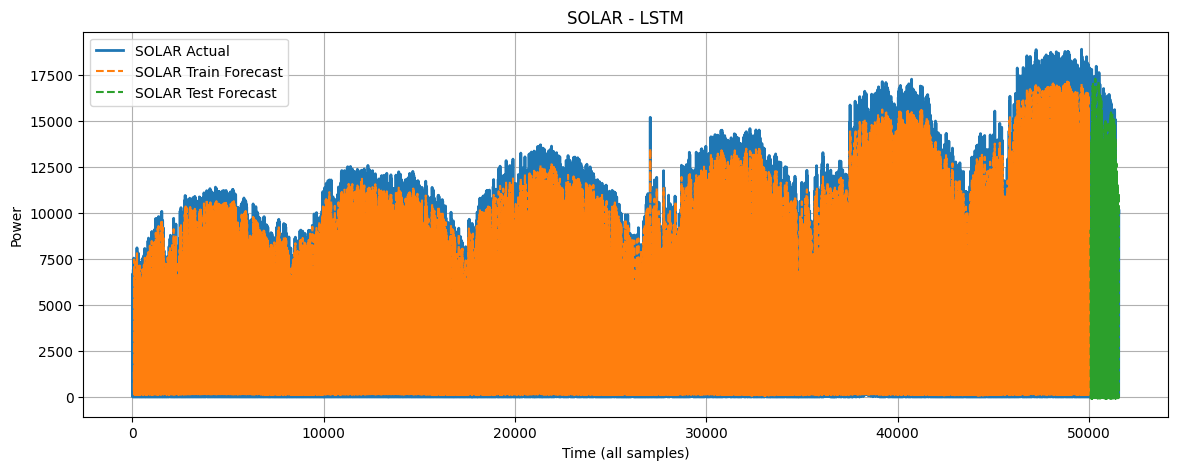

In [ ]:
df_sub = df_solar
feature_cols= SOLAR_FEATURES
label_name= "SOLAR"

prep = prepare_lstm_data(df_sub, feature_cols, label_name)

model, history = train_lstm(
  prep["X_train"], prep["y_train"],prep["X_test"],prep["y_test"], label_name
)

result = evaluate_lstm(
  model,
  prep["X_train"], prep["y_train"],
  prep["X_test"], prep["y_test"],
  prep["scaler_y"],
  prep["target_raw"],
  prep["train_size"],
  label_name,
  plot=True,
)

result["models"][0]["scaler_x"] = prep["scaler_x"]
scaler_x = result["models"][0]["scaler_x"]

In [ ]:
model.save("solar_lstm_model.keras")

In [ ]:
import joblib

joblib.dump(prep["scaler_x"], "solar_scaler_x.joblib")
joblib.dump(prep["scaler_y"], "solar_scaler_y.joblib")
print("Saved scalers.")

Saved scalers.


In [ ]:
def accuracy_overtime(actual, pred, threshold=100, smooth_window=None):
    actual = actual.flatten()
    pred   = pred.flatten()

    if smooth_window is not None and smooth_window > 1:
        import pandas as pd
        actual = pd.Series(actual).rolling(
            smooth_window, center=True, min_periods=1
        ).mean().values
        pred   = pd.Series(pred).rolling(
            smooth_window, center=True, min_periods=1
        ).mean().values

    actual_diff = np.diff(actual)
    pred_diff   = np.diff(pred)

    def to_dir(d):
        d = np.where(np.abs(d) < threshold, 0, d)
        return np.sign(d)

    actual_dir = to_dir(actual_diff)
    pred_dir   = to_dir(pred_diff)

    correct = np.sum(actual_dir == pred_dir)
    total   = len(actual_dir)
    acc     = correct / total if total > 0 else 0
    return acc * 100, actual_dir, pred_dir

In [ ]:
solar_acc, solar_actual_dir, solar_pred_dir = accuracy_overtime(
    result["actual"],
    result["pred"],
    threshold=100,
    smooth_window=5
)

print(f"SOLAR - Directional Accuracy: {solar_acc:.2f}%")

SOLAR - Directional Accuracy: 95.32%
